### Optimizing Rumor Detection: A Dual Feature Extraction Approach with LIME-Based Model Explanation

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords, wordnet
# from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold



from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import joblib

In [14]:
# dataset link = https://www.kaggle.com/c/fake-news/data

In [15]:
df = pd.read_csv("train.csv")

In [16]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [17]:
df.shape

(20800, 5)

In [18]:
df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

1 ==> unreliable / rumor

0 ==> reliable / non-rumor

Balanced Class Labels

In [19]:
df = df.drop(['id', 'author', 'title'], axis = 1)
df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB


### Null value

In [21]:
df.isnull().sum()

text     39
label     0
dtype: int64

In [22]:
# The forwardfill() method is used to fill in missing values 
# in a DataFrame or Series with the previous valid observation

df['text'].fillna(method='ffill', inplace=True)

In [23]:
df.isnull().sum()

text     0
label    0
dtype: int64

### Duplicate value

In [24]:
df.duplicated().value_counts()

False    20409
True       391
dtype: int64

In [25]:
# dropping Duplicates

df = df.drop_duplicates(keep='first')

In [26]:
df.duplicated().value_counts()

False    20409
dtype: int64

In [27]:
df.shape

(20409, 2)

## Preprocessing

### Data Cleaning

In [28]:
# Ensure you have the necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Constants for cleaning
PUNCT_TO_REMOVE = string.punctuation + '“”'
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [29]:
# Combine all cleaning functions
def clean_text(text, FREQWORDS=None, RAREWORDS=None):
    if isinstance(text, str):
        # 1. Convert to lowercase
        text = text.lower()
        
        # 2. Remove punctuation
        text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
        
        # 3. Remove hyperlinks, markup, numbers, and special symbols
        text = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', text)
        text = re.sub('&gt;', "", text)  # Greater than sign
        text = re.sub('&#x27;', "'", text)  # Apostrophe
        text = re.sub('&quot;', '"', text)
        text = re.sub('&#x2F;', ' ', text)
        text = re.sub('<p>', ' ', text)  # Paragraph tag
        text = re.sub('<i>', ' ', text)  # Italics tag
        text = re.sub('</i>', '', text)
        text = re.sub('&#62;', '', text)
        text = re.sub("\n", '', text)  # Newline
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r"[’']", "", text)  # Remove special apostrophes

        # 4. Remove stopwords
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        
        # 5. Remove frequent words if provided
        if FREQWORDS:
            text = " ".join([word for word in text.split() if word not in FREQWORDS])
        
        # 6. Remove rare words if provided
        if RAREWORDS:
            text = " ".join([word for word in text.split() if word not in RAREWORDS])
        
        # 7. Lemmatization
        pos_tagged_text = nltk.pos_tag(text.split())
        text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
        
        # 8. Remove URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)
        
    return text

In [30]:
# Apply the cleaning function on the dataset
def preprocess_df(df):
    # Remove URLs, Punctuation, Lowercase, etc. in one go
    df["text"] = df["text"].apply(lambda text: clean_text(text))

    # Get frequent words and remove them
    cnt = Counter()
    for text in df["text"].values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    
    # Get rare words and remove them
    rare_word_count = pd.Series(' '.join(df['text']).split()).value_counts()[-2:]
    RAREWORDS = list(rare_word_count.index)
    
    # Apply removal of frequent and rare words
    df["text"] = df["text"].apply(lambda text: clean_text(text, FREQWORDS=FREQWORDS, RAREWORDS=RAREWORDS))

    return df

In [31]:
# Use the function to clean and preprocess the dataframe
df = preprocess_df(df)
df.head()

,text,label
0,house dem aide didnt even see comeys letter ja...,1
1,ever get feeling life circle roundabout rather...,0
2,truth might get fired october tension intellig...,1
3,video civilian kill single u airstrike identif...,1
4,print iranian woman sentence six prison iran r...,1


## Split Data

In [32]:
X = df['text']  # Features
y = df['label'] # Target

In [33]:
print(X[:1])

0    house dem aide didnt even see comeys letter ja...
Name: text, dtype: object


In [34]:
print(y)

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20409, dtype: int64


### Feature Extraction

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Custom parameters for CountVectorizer
# count_vect = CountVectorizer(max_features=10000, ngram_range=(1, 2))

# Custom parameters for TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [36]:
# Apply CountVectorizer
# X_count = count_vect.fit_transform(X)


# Apply TfidfVectorizer
X_tfidf = tfidf_vect.fit_transform(X)

In [37]:
# Example of correct data splitting
# X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [38]:
# print(f"X_train_count shape: {X_train_count.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test_count shape: {X_test_count.shape}")
# print(f"y_test shape: {y_test.shape}")

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"y_train shape: {y_test.shape}")

X_train_tfidf shape: (16327, 10000)
y_train shape: (16327,)
X_test_tfidf shape: (4082, 10000)
y_train shape: (4082,)


## Model Training - TFIDF

### 1. Logistic Regression

Cross-Validation Accuracy Scores: [0.93539498 0.93417024 0.93292496 0.93629403 0.93323124]
Mean Cross-Validation Accuracy: 0.9344
Logistic Regression with TfidfVectorizer:
Accuracy: 0.9434
Precision: 0.9391
Recall: 0.9434
F1 Score: 0.9413

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2120
           1       0.94      0.94      0.94      1962

    accuracy                           0.94      4082
   macro avg       0.94      0.94      0.94      4082
weighted avg       0.94      0.94      0.94      4082



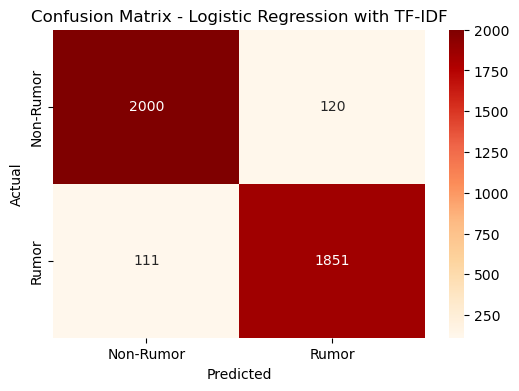

In [39]:
# Initialize the Logistic Regression model
log_reg_tf = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0, penalty='l2')


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(log_reg_tf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


# Train the model on the TF-IDF features
log_reg_tf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf = log_reg_tf.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf)
recall_tfidf = recall_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

# Print the evaluation results
print(f"Logistic Regression with TfidfVectorizer:")
print(f"Accuracy: {accuracy_tfidf:.4f}")
print(f"Precision: {precision_tfidf:.4f}")
print(f"Recall: {recall_tfidf:.4f}")
print(f"F1 Score: {f1_tfidf:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

# Plot confusion matrix
conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tfidf, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression with TF-IDF')
plt.show()

In [40]:
# Save the trained model to a file

joblib.dump(log_reg_tf, 'logistic_regression_model_tfidf.pkl')

['logistic_regression_model_tfidf.pkl']

### 2. Naive Bayes

Cross-Validation Accuracy Scores: [0.89957134 0.8821188  0.88820827 0.89188361 0.89372129]
Mean Cross-Validation Accuracy: 0.8911
Naive Bayes with TfidfVectorizer:
Accuracy: 0.8922
Precision: 0.9145
Recall: 0.8558
F1 Score: 0.8841

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2120
           1       0.91      0.86      0.88      1962

    accuracy                           0.89      4082
   macro avg       0.89      0.89      0.89      4082
weighted avg       0.89      0.89      0.89      4082



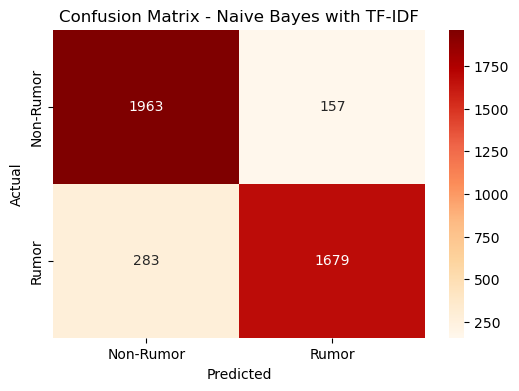

In [41]:
# Initialize the Naive Bayes model
naive_bayes_tf = MultinomialNB(alpha=1.0, fit_prior=True)


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(naive_bayes_tf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


# Train the model on the TF-IDF features
naive_bayes_tf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf_nb = naive_bayes_tf.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_tfidf_nb = accuracy_score(y_test, y_pred_tfidf_nb)
precision_tfidf_nb = precision_score(y_test, y_pred_tfidf_nb)
recall_tfidf_nb = recall_score(y_test, y_pred_tfidf_nb)
f1_tfidf_nb = f1_score(y_test, y_pred_tfidf_nb)

# Print the evaluation results
print(f"Naive Bayes with TfidfVectorizer:")
print(f"Accuracy: {accuracy_tfidf_nb:.4f}")
print(f"Precision: {precision_tfidf_nb:.4f}")
print(f"Recall: {recall_tfidf_nb:.4f}")
print(f"F1 Score: {f1_tfidf_nb:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_nb))

# Plot confusion matrix
conf_matrix_tfidf_nb = confusion_matrix(y_test, y_pred_tfidf_nb)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tfidf_nb, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Naive Bayes with TF-IDF')
plt.show()

In [42]:
# Save the trained model to a file

joblib.dump(naive_bayes_tf, 'naive_bayes_model_tfidf.pkl')

['naive_bayes_model_tfidf.pkl']

### 3. Stochastic Gradient Descent (SGD)

Cross-Validation Accuracy Scores: [0.94182486 0.94396816 0.94303216 0.943951   0.94180704]
Mean Cross-Validation Accuracy: 0.9429
SGD Classifier with TfidfVectorizer:
Accuracy: 0.9495
Precision: 0.9470
Recall: 0.9480
F1 Score: 0.9475

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2120
           1       0.95      0.95      0.95      1962

    accuracy                           0.95      4082
   macro avg       0.95      0.95      0.95      4082
weighted avg       0.95      0.95      0.95      4082



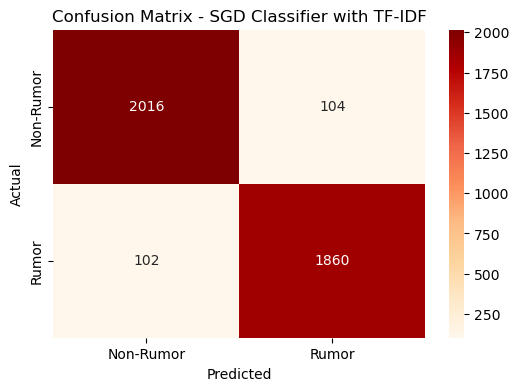

In [43]:
# Initialize the Stochastic Gradient Descent (SGD) Classifier
sgd_tf = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, tol=1e-3, random_state=42)


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(sgd_tf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")



# Train the model on the TF-IDF features
sgd_tf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf_sgd = sgd_tf.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_tfidf_sgd = accuracy_score(y_test, y_pred_tfidf_sgd)
precision_tfidf_sgd = precision_score(y_test, y_pred_tfidf_sgd)
recall_tfidf_sgd = recall_score(y_test, y_pred_tfidf_sgd)
f1_tfidf_sgd = f1_score(y_test, y_pred_tfidf_sgd)

# Print the evaluation results
print(f"SGD Classifier with TfidfVectorizer:")
print(f"Accuracy: {accuracy_tfidf_sgd:.4f}")
print(f"Precision: {precision_tfidf_sgd:.4f}")
print(f"Recall: {recall_tfidf_sgd:.4f}")
print(f"F1 Score: {f1_tfidf_sgd:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_sgd))

# Plot confusion matrix
conf_matrix_tfidf_sgd = confusion_matrix(y_test, y_pred_tfidf_sgd)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tfidf_sgd, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SGD Classifier with TF-IDF')
plt.show()

In [44]:
# Save the trained model to a file

joblib.dump(sgd_tf, 'stochastic_gradient_descent_model_tfidf.pkl')

['stochastic_gradient_descent_model_tfidf.pkl']

### 4. K-Nearest Neighbors (KNN)

Cross-Validation Accuracy Scores: [0.56889161 0.56858543 0.56355283 0.56539051 0.56079632]
Mean Cross-Validation Accuracy: 0.5654
K-Nearest Neighbors with TfidfVectorizer:
Accuracy: 0.5732
Precision: 0.5302
Recall: 0.9857
F1 Score: 0.6895

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.19      0.32      2120
           1       0.53      0.99      0.69      1962

    accuracy                           0.57      4082
   macro avg       0.73      0.59      0.50      4082
weighted avg       0.74      0.57      0.50      4082



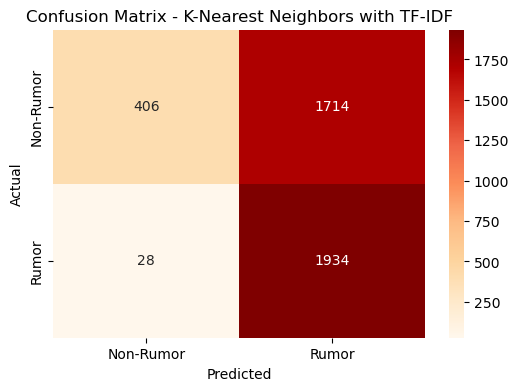

In [45]:
# Initialize the K-Nearest Neighbors (KNN) Classifier
knn_tf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # p=2 is Euclidean distance


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(knn_tf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

# Train the model on the TF-IDF features
knn_tf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf_knn = knn_tf.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_tfidf_knn = accuracy_score(y_test, y_pred_tfidf_knn)
precision_tfidf_knn = precision_score(y_test, y_pred_tfidf_knn)
recall_tfidf_knn = recall_score(y_test, y_pred_tfidf_knn)
f1_tfidf_knn = f1_score(y_test, y_pred_tfidf_knn)

# Print the evaluation results
print(f"K-Nearest Neighbors with TfidfVectorizer:")
print(f"Accuracy: {accuracy_tfidf_knn:.4f}")
print(f"Precision: {precision_tfidf_knn:.4f}")
print(f"Recall: {recall_tfidf_knn:.4f}")
print(f"F1 Score: {f1_tfidf_knn:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_knn))

# Plot confusion matrix
conf_matrix_tfidf_knn = confusion_matrix(y_test, y_pred_tfidf_knn)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tfidf_knn, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - K-Nearest Neighbors with TF-IDF')
plt.show()

In [46]:
# Save the trained model to a file

joblib.dump(knn_tf, 'k-nearest_neighbors_model_tfidf.pkl')

['k-nearest_neighbors_model_tfidf.pkl']

### 5. Decision Tree

Cross-Validation Accuracy Scores: [0.83374158 0.83312921 0.81776417 0.81225115 0.8330781 ]
Mean Cross-Validation Accuracy: 0.8260
Decision Tree with TfidfVectorizer:
Accuracy: 0.8462
Precision: 0.8348
Recall: 0.8476
F1 Score: 0.8412

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2120
           1       0.83      0.85      0.84      1962

    accuracy                           0.85      4082
   macro avg       0.85      0.85      0.85      4082
weighted avg       0.85      0.85      0.85      4082



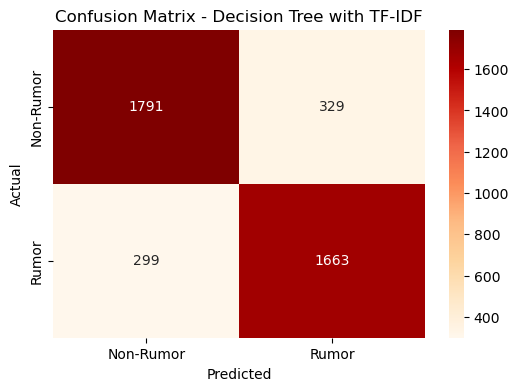

In [47]:
# Initialize the Decision Tree Classifier
decision_tree_tf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=42)

# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(decision_tree_tf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

# Train the model on the TF-IDF features
decision_tree_tf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf_dt = decision_tree_tf.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_tfidf_dt = accuracy_score(y_test, y_pred_tfidf_dt)
precision_tfidf_dt = precision_score(y_test, y_pred_tfidf_dt)
recall_tfidf_dt = recall_score(y_test, y_pred_tfidf_dt)
f1_tfidf_dt = f1_score(y_test, y_pred_tfidf_dt)

# Print the evaluation results
print(f"Decision Tree with TfidfVectorizer:")
print(f"Accuracy: {accuracy_tfidf_dt:.4f}")
print(f"Precision: {precision_tfidf_dt:.4f}")
print(f"Recall: {recall_tfidf_dt:.4f}")
print(f"F1 Score: {f1_tfidf_dt:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_dt))

# Plot confusion matrix
conf_matrix_tfidf_dt = confusion_matrix(y_test, y_pred_tfidf_dt)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tfidf_dt, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Decision Tree with TF-IDF')
plt.show()

In [48]:
# Save the trained model to a file

joblib.dump(decision_tree_tf, 'decision_tree_model_tfidf.pkl')

['decision_tree_model_tfidf.pkl']

### 6. Random Forest

Cross-Validation Accuracy Scores: [0.91488059 0.91365585 0.92312404 0.91914242 0.92128637]
Mean Cross-Validation Accuracy: 0.9184
Random Forest with TfidfVectorizer:
Accuracy: 0.9290
Precision: 0.9395
Recall: 0.9108
F1 Score: 0.9249

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2120
           1       0.94      0.91      0.92      1962

    accuracy                           0.93      4082
   macro avg       0.93      0.93      0.93      4082
weighted avg       0.93      0.93      0.93      4082



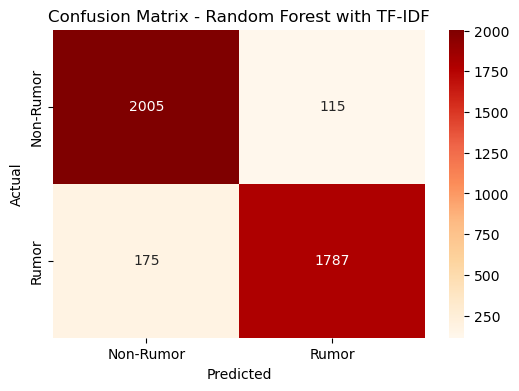

In [49]:
# Initialize the Random Forest model
random_forest_tf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42, n_jobs=-1)

# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(random_forest_tf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

# Train the model on the TF-IDF features
random_forest_tf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf_rf = random_forest_tf.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_tfidf_rf = accuracy_score(y_test, y_pred_tfidf_rf)
precision_tfidf_rf = precision_score(y_test, y_pred_tfidf_rf)
recall_tfidf_rf = recall_score(y_test, y_pred_tfidf_rf)
f1_tfidf_rf = f1_score(y_test, y_pred_tfidf_rf)

# Print the evaluation results
print(f"Random Forest with TfidfVectorizer:")
print(f"Accuracy: {accuracy_tfidf_rf:.4f}")
print(f"Precision: {precision_tfidf_rf:.4f}")
print(f"Recall: {recall_tfidf_rf:.4f}")
print(f"F1 Score: {f1_tfidf_rf:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_rf))

# Plot confusion matrix
conf_matrix_tfidf_rf = confusion_matrix(y_test, y_pred_tfidf_rf)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tfidf_rf, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest with TF-IDF')
plt.show()

In [50]:
# Save the trained model to a file

joblib.dump(random_forest_tf, 'random_forest_model_tfidf.pkl')

['random_forest_model_tfidf.pkl']

### 7. Support Vector Machine (SVM)

In [51]:
# ================ without cross validation =================

# # Initialize the Support Vector Machine model
# svm_tf = SVC(kernel='linear', C=1.0, random_state=42)

# # Train the model on the TF-IDF features
# svm_tf.fit(X_train_tfidf, y_train)

# # Predict on the test set
# y_pred_tfidf_svm = svm_tf.predict(X_test_tfidf)

# # Evaluation Metrics
# accuracy_tfidf_svm = accuracy_score(y_test, y_pred_tfidf_svm)
# precision_tfidf_svm = precision_score(y_test, y_pred_tfidf_svm)
# recall_tfidf_svm = recall_score(y_test, y_pred_tfidf_svm)
# f1_tfidf_svm = f1_score(y_test, y_pred_tfidf_svm)

# # Print the evaluation results
# print(f"Support Vector Machine with TfidfVectorizer:")
# print(f"Accuracy: {accuracy_tfidf_svm:.4f}")
# print(f"Precision: {precision_tfidf_svm:.4f}")
# print(f"Recall: {recall_tfidf_svm:.4f}")
# print(f"F1 Score: {f1_tfidf_svm:.4f}")

# # Print classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_tfidf_svm))

# # Plot confusion matrix
# conf_matrix_tfidf_svm = confusion_matrix(y_test, y_pred_tfidf_svm)
# plt.figure(figsize=(6,4))
# sns.heatmap(conf_matrix_tfidf_svm, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix - Support Vector Machine with TF-IDF')
# plt.show()

Cross-Validation Accuracy Scores: [0.94213105 0.94243723 0.9424196  0.94548239 0.9424196 ]
Mean Cross-Validation Accuracy: 0.9430
Support Vector Machine with TfidfVectorizer:
Accuracy: 0.9503
Precision: 0.9467
Recall: 0.9501
F1 Score: 0.9484

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2120
           1       0.95      0.95      0.95      1962

    accuracy                           0.95      4082
   macro avg       0.95      0.95      0.95      4082
weighted avg       0.95      0.95      0.95      4082



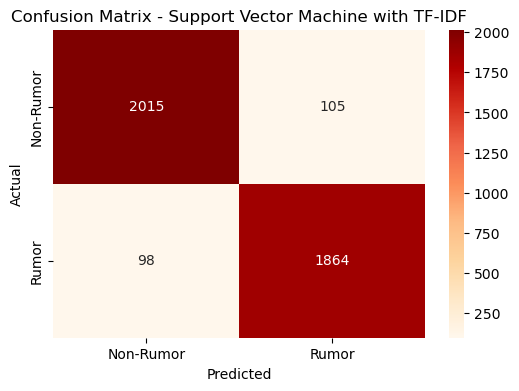

In [52]:
# Initialize the Support Vector Machine model
svm_model_tf = SVC(kernel='linear', C=1.0, random_state=42)

# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(svm_model_tf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

# Train the model on the full training data
svm_model_tf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf_svm = svm_model_tf.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_tfidf_svm = accuracy_score(y_test, y_pred_tfidf_svm)
precision_tfidf_svm = precision_score(y_test, y_pred_tfidf_svm)
recall_tfidf_svm = recall_score(y_test, y_pred_tfidf_svm)
f1_tfidf_svm = f1_score(y_test, y_pred_tfidf_svm)

# Print the evaluation results
print(f"Support Vector Machine with TfidfVectorizer:")
print(f"Accuracy: {accuracy_tfidf_svm:.4f}")
print(f"Precision: {precision_tfidf_svm:.4f}")
print(f"Recall: {recall_tfidf_svm:.4f}")
print(f"F1 Score: {f1_tfidf_svm:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_svm))

# Plot confusion matrix
conf_matrix_tfidf_svm = confusion_matrix(y_test, y_pred_tfidf_svm)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tfidf_svm, annot=True, fmt='d', cmap='OrRd', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Support Vector Machine with TF-IDF')
plt.show()

In [53]:
# Save the trained model to a file

joblib.dump(svm_model_tf, 'svm_model_tfidf.pkl')

['svm_model_tfidf.pkl']